In [1]:
#importing packages
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import fiona
from fiona import Feature, Geometry
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import rasterio as rio
from rasterio.enums import Resampling
import skgstat as skg
import sys
# Import necessary libraries and modules
sys.path.append('/S:/mc5545/SA_Drone_data')
from texture import fastglcm_wrapper
from scipy.stats import skew, kurtosis

In [2]:
#stacked Green, Red, Red Edge, and Near Infrared band individual rasters into one multi-band raster
top_path='S:/mc5545/SA_Drone_data/'

In [3]:
raster_path1 = top_path+'burnplot18_lr/reflectance'
raster_filename1 = 'burnplot18_lr_band_stack.tif'

raster_path2 = top_path+'burn2016_lr/reflectance'
raster_filename2 = 'burn2016_lr_band_stack.tif'

raster_path3 = top_path+'burn2017&2016_lr/reflectance'
raster_filename3 = 'burn2017&2016_lr_band_stack.tif'

raster_path4 = top_path+'burn2019_lr/reflectance'
raster_filename4 = 'burn2019_lr_band_stack.tif'

raster_path5 = top_path+'burnplot17_lr/reflectance'
raster_filename5 = 'burnplot17_lr_band_stack.tif'

raster_path6 = top_path+'burn2022_lr/reflectance'
raster_filename6 = 'burn2022_lr_band_stack.tif'

# Small ROI

In [14]:
shapefiles1 = gpd.read_file(Path(top_path,'burnplot18_lr/burnplot18_lr_shape/burnplot18_lr_shp.shp'))
shapefiles2 = gpd.read_file(Path(top_path,'burn2016_lr/burn2016_lr_shape/burn2016_lr_shp.shp'))
shapefiles3 = gpd.read_file(Path(top_path,'burn2017&2016_lr/burn2017_shape/burn2017_shp.shp'))
shapefiles4 = gpd.read_file(Path(top_path,'burn2019_lr/burn2019_lr_shape/burn2019_lr_shp.shp'))
shapefiles5 = gpd.read_file(Path(top_path,'burnplot17_lr/burnplot17_lr_shape/burnplot17_lr_shp.shp'))
shapefiles6 = gpd.read_file(Path(top_path,'burn2022_lr/burn2022_lr_shape/burn2022_lr_shp.shp'))

# For whole scene

In [5]:
shapefiles1 = gpd.read_file(Path(top_path,'burnplot18_lr/burnplot18_lr_shape_all/burnplot18_lr_shp.shp'))
shapefiles2 = gpd.read_file(Path(top_path,'burn2016_lr/burn2016_lr_shape_all/burn2016_shp.shp'))
shapefiles3 = gpd.read_file(Path(top_path,'burn2017&2016_lr/burn2017_shape/burn2017_shp.shp'))
shapefiles4 = gpd.read_file(Path(top_path,'burn2019_lr/burn2019_lr_shape_all/burn2019_lr_shp.shp'))
shapefiles5 = gpd.read_file(Path(top_path,'burnplot17_lr/burnplot17_lr_shape_all/burnplot17_lr_shp.shp'))
shapefiles6 = gpd.read_file(Path(top_path,'burn2022_lr/burn2022_lr_shape_all/burn2022_lr_shp.shp'))

# For 2022 Field Trip shapefiles

In [4]:
shapefiles1 = gpd.read_file(Path(top_path,'from 2022 trip/shapefiles_rob/2006/P18_5b10.shp'))#
shapefiles2 = gpd.read_file(Path(top_path,'from 2022 trip/shapefiles_rob/2016_1/P2016_5b5.shp'))
shapefiles3 = gpd.read_file(Path(top_path,'from 2022 trip/shapefiles_rob/2016_2/P2017_5b5.shp'))
shapefiles4 = gpd.read_file(Path(top_path,'from 2022 trip/shapefiles_rob/2019/P2019_5b5.shp'))
shapefiles5 = gpd.read_file(Path(top_path,'from 2022 trip/shapefiles_rob/2020/P17_5b10.shp'))


In [5]:
# load raster1
def fynbos_texture(raster_path, raster_filename, shapefiles):
    # Open the raster using rasterio
    raster = rxr.open_rasterio(Path(raster_path, raster_filename), masked=True).squeeze()
    geometries = shapefiles.geometry.apply(mapping)
    
    # Create an empty list to store the clipped rasters
    clipped_rasters = []
    for i in range(len(shapefiles)):
        # Clip the raster with the current geometry
        p1 = raster.rio.clip([geometries[i]], shapefiles.crs)
        # Convert the clipped raster to a NumPy array
        p1_np = np.asarray(p1)
        # Append the clipped raster array to the list
        clipped_rasters.append(p1_np)


    
    # Initialize an empty list to store results for all rasters
    data_list  = []
    data_list1 = []
    data_list2 = [] 
    data_list3 = []
    data_list4 = [] 
    data_list5 = []
    data_list6 = []
    data_list7 = []
    data_list8 = []
    # Loop through each raster
    for idx, raster in enumerate(clipped_rasters):
        # Transpose the raster to have the band order (G, R, RE, NIR)
        raster = np.transpose(raster, (1, 2, 0))
        
        # Create an instance of the fastglcm_wrapper class
        # Specify the parameters: levels, kernel_size, distance_offset, and angles
        tex2 = fastglcm_wrapper(raster, levels=8, kernel_size=5, distance_offset=5, angles=[0, 45, 90, 135])
       
        # Calculate various GLCM matrices
        mean = tex2.calculate_glcm_mean()
        variance = tex2.calculate_glcm_var()
        contrast = tex2.calculate_glcm_contrast()
        dissimilarity = tex2.calculate_glcm_dissimilarity()
        homogeneity = tex2.calculate_glcm_homogenity()
        asm = tex2.calculate_glcm_asm()
        entropy = tex2.calculate_glcm_entropy()
        maximum = tex2.calculate_glcm_max()
        correlation = tex2.calculate_glcm_correlation()

        # Function to calculate statistics for each GLCM matrix
        def calculate_stats(tex_features, prefix):
            mean_tex_features = np.nanmean(tex_features, axis=(0, 1))
            std_tex_features = np.nanstd(tex_features, axis=(0, 1))
            skewness_tex_features = skew(tex_features, axis=(0, 1), nan_policy='omit')
            kurtosis_tex_features = kurtosis(tex_features, axis=(0, 1), nan_policy='omit')
            CV_tex_features = (std_tex_features / mean_tex_features)
            
            # Create dictionary keys with the provided prefix
            keys = [f'{prefix}_{param}' for param in ['mean', 'std', 'skewness', 'kurtosis', 'CV']]
            # Inside the calculate_stats function, before returning the dictionary
            #print(f'Keys: {keys}')
            #print(f'Dictionary: {dict(zip(keys, [mean_tex_features, std_tex_features, skewness_tex_features, kurtosis_tex_features, CV_tex_features]))}')

            # Return results in a dictionary
            return dict(zip(keys, [mean_tex_features, std_tex_features, skewness_tex_features, 
                                   kurtosis_tex_features, CV_tex_features]))

        # Calculate statistics for each GLCM matrix and append the results to the list
        data_list.append(calculate_stats(mean, 'mean'))
        data_list1.append(calculate_stats(variance, 'variance'))
        data_list2.append(calculate_stats(contrast, 'contrast'))
        data_list3.append(calculate_stats(dissimilarity, 'dissimilarity'))
        data_list4.append(calculate_stats(homogeneity, 'homogeneity'))
        data_list5.append(calculate_stats(asm, 'asm'))
        data_list6.append(calculate_stats(entropy, 'entropy'))
        data_list7.append(calculate_stats(maximum, 'maximum'))
        data_list8.append(calculate_stats(correlation, 'correlation'))

    # Extract and organize values into arrays
    parameters  = ['mean_CV', 'mean_kurtosis', 'mean_mean', 'mean_skewness', 'mean_std']
    parameters1 = ['variance_CV', 'variance_kurtosis', 'variance_mean', 'variance_skewness', 'variance_std']
    parameters2 = ['contrast_CV', 'contrast_kurtosis', 'contrast_mean', 'contrast_skewness', 'contrast_std']
    parameters3 = ['dissimilarity_CV', 'dissimilarity_kurtosis', 'dissimilarity_mean', 'dissimilarity_skewness', 'dissimilarity_std']
    parameters4 = ['homogeneity_CV', 'homogeneity_kurtosis', 'homogeneity_mean', 'homogeneity_skewness', 'homogeneity_std']
    parameters5 = ['asm_CV', 'asm_kurtosis', 'asm_mean', 'asm_skewness', 'asm_std']
    parameters6 = ['entropy_CV', 'entropy_kurtosis', 'entropy_mean', 'entropy_skewness', 'entropy_std']
    parameters7 = ['maximum_CV', 'maximum_kurtosis', 'maximum_mean', 'maximum_skewness', 'maximum_std']
    parameters8 = ['correlation_CV', 'correlation_kurtosis', 'correlation_mean', 'correlation_skewness', 'correlation_std']
    bands = ['band1', 'band2', 'band3', 'band4']

    data = {}
    for parameter in parameters:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data[key] = np.array([d[parameter][band_index - 1] for d in data_list])
             
    data1 = {}
    for parameter in parameters1:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data1[key] = np.array([d[parameter][band_index - 1] for d in data_list1])

    data2 = {}
    for parameter in parameters2:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data2[key] = np.array([d[parameter][band_index - 1] for d in data_list2])

    data3 = {}
    for parameter in parameters3:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data3[key] = np.array([d[parameter][band_index - 1] for d in data_list3])

    data4 = {}
    for parameter in parameters4:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data4[key] = np.array([d[parameter][band_index - 1] for d in data_list4])

    data5 = {}
    for parameter in parameters5:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data5[key] = np.array([d[parameter][band_index - 1] for d in data_list5])


    data6 = {}
    for parameter in parameters6:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data6[key] = np.array([d[parameter][band_index - 1] for d in data_list6])


    data7 = {}
    for parameter in parameters7:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data7[key] = np.array([d[parameter][band_index - 1] for d in data_list7])

    data8 = {}
    for parameter in parameters8:
         for band_index, band in enumerate(bands, start=1):
             key = f"{parameter}_{band}"
             data8[key] = np.array([d[parameter][band_index - 1] for d in data_list8])
             

    # Create a DataFrame
    df = pd.DataFrame(data)
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    df3 = pd.DataFrame(data3)
    df4 = pd.DataFrame(data4)
    df5 = pd.DataFrame(data5)
    df6 = pd.DataFrame(data6)
    df7 = pd.DataFrame(data7)
    df8 = pd.DataFrame(data8)
    
    # Concatenate them along the columns (axis=1)
    result_df = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8], axis=1)
    # Print the result DataFrame
    #print(result_df)

    return result_df

In [6]:
df1=fynbos_texture(raster_path1, raster_filename1, shapefiles1)
df2=fynbos_texture(raster_path2, raster_filename2, shapefiles2)
df3=fynbos_texture(raster_path3, raster_filename3, shapefiles3)
df4=fynbos_texture(raster_path4, raster_filename4, shapefiles4)
df5=fynbos_texture(raster_path5, raster_filename5, shapefiles5)
#df6=fynbos_texture(raster_path6, raster_filename6, shapefiles6)

C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\mc5545\.conda\envs\ag_env\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, a

In [8]:
# directory_path='S:/mc5545/SA_Drone_data/textures_csv/'
# # Save DataFrame to a CSV file with index
# df1.to_csv(f'{directory_path}textures_2006_burnplot18.csv')
# df2.to_csv(f'{directory_path}textures_2016_burn2016.csv')
# df3.to_csv(f'{directory_path}textures_2017_burn2017.csv')
# df4.to_csv(f'{directory_path}textures_2019_burn2019.csv')
# df5.to_csv(f'{directory_path}textures_2020_burnplot17.csv')
# df6.to_csv(f'{directory_path}textures_2022_burn2022.csv')


In [7]:
# # For 2022 Field Trip shape files

# directory_path='S:/mc5545/SA_Drone_data/from 2022 trip/textures_csv/'
# # Save DataFrame to a CSV file with index
# df1.to_csv(f'{directory_path}textures_2006.csv')
# df2.to_csv(f'{directory_path}textures_2016_1.csv')
# df3.to_csv(f'{directory_path}textures_2016_2.csv')
# df4.to_csv(f'{directory_path}textures_2019.csv')
# df5.to_csv(f'{directory_path}textures_2020.csv')

In [4]:
directory_path='S:/mc5545/SA_Drone_data/textures_csv/'

# Load DataFrame from the CSV file
df1 = pd.read_csv(f'{directory_path}textures_2006_burnplot18.csv', index_col=0)
df2 = pd.read_csv(f'{directory_path}textures_2016_burn2016.csv', index_col=0)
df3 = pd.read_csv(f'{directory_path}textures_2017_burn2017.csv', index_col=0)
df4 = pd.read_csv(f'{directory_path}textures_2019_burn2019.csv', index_col=0)
df5 = pd.read_csv(f'{directory_path}textures_2020_burnplot17.csv', index_col=0)
df6 = pd.read_csv(f'{directory_path}textures_2022_burn2022.csv', index_col=0)

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings


def plot_ridge_histograms(dataframes, column_name, years):
    
    # Suppress warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    # Create a DataFrame for seaborn
    frames = [pd.DataFrame({'Value': df[column_name], 'Year': year}) for year, df in zip(years, dataframes)]
    data_concat = pd.concat(frames)
    
    # Set seaborn style
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
    palette = sns.color_palette("Set2", 6)
    # Create a FacetGrid
    g = sns.FacetGrid(data_concat, palette=palette, row="Year", hue="Year", aspect=9, height=1.2)
    # Map the ridge plot
    g.map_dataframe(sns.kdeplot, x="Value", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Value", color='black')
    
    # Define a function to label the plots
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=16, ha="left", va="center", transform=ax.transAxes)
    # Apply the labels
    g.map(label, "Year")
    # Adjust layout
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    #g.set(yticks=[], xlabel=f"{column_name.capitalize()} Value")
    g.set(yticks=[], xlabel=f"{column_name} Value")
    #g.set(yticks=[], xlabel=f"CV of homogeneity_NIR Value")
    # Access underlying Matplotlib axes
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', labelsize=18)  # Increase x-axis tick font size
        ax.set_xlabel(ax.get_xlabel(), fontsize=18,fontweight='bold')  # Increase x-axis label font size
        ax.set_ylabel('')  # Remove y-axis label
        
        # Make x-axis tick labels bold
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')
        # Make y-axis tick labels bold
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
    g.despine(left=True)
    
    # Set the main title
    #plt.suptitle(f'Ridge Plot of CV of homogeneity_NIR for Different Years', y=0.98,fontsize=18,fontweight='bold')
    plt.suptitle(f'Ridge Plot of {column_name} for Different Years', y=0.98,fontsize=18,fontweight='bold')
    #plt.suptitle(f'Ridge Plot of {column_name.capitalize()} for Different Years', y=0.98,fontsize=18)
    # Show the plot
    plt.show()

# Assuming dataframes is a list of your 6 DataFrames and 'NDVI' is the column


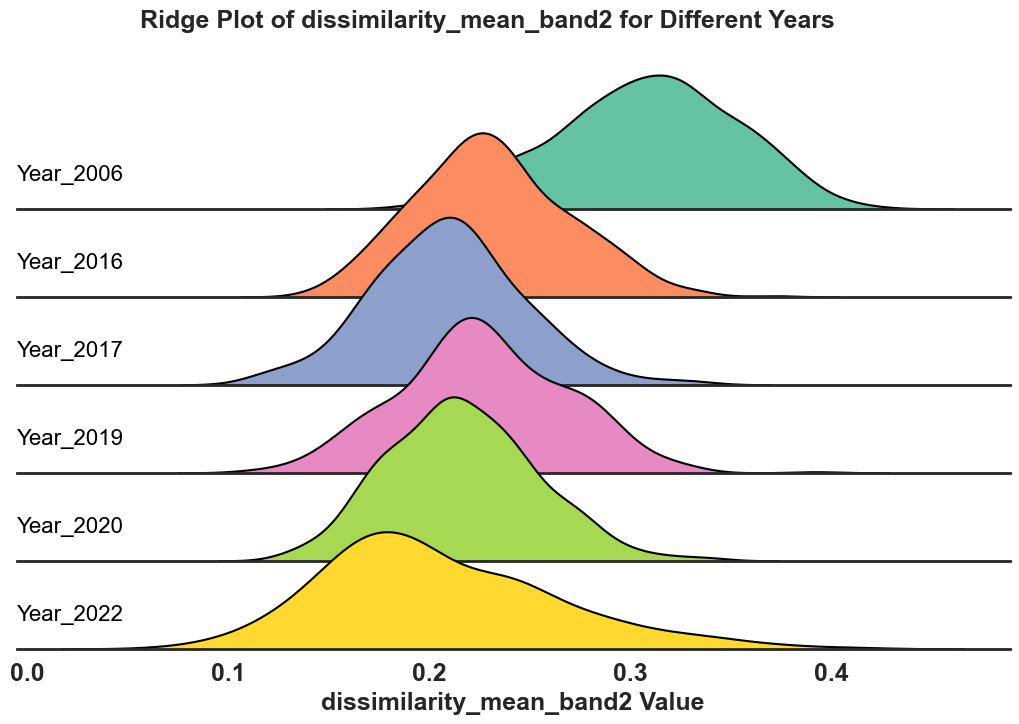

In [7]:

# Transpose the raster to have the band order (G, R, RE, NIR)
# Example usage
column_name = 'dissimilarity_mean_band2'
dataframes = [df1, df2, df3, df4, df5,df6]
years = ['Year_2006', 'Year_2016', 'Year_2017', 'Year_2019', 'Year_2020', 'Year_2022']
plot_ridge_histograms(dataframes, 'dissimilarity_mean_band2', years)

In [8]:
#https://pypi.org/project/scikit-posthocs/


def statistical_test(dataframes,column_name):
    
    # Assuming dataframes is your list of dataframes
    VI_values = [df[column_name].dropna().values for df in dataframes]
    
    from scipy.stats import kruskal
    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*VI_values)
    print(f'Kruskal-Wallis Test - Statistic: {stat}, p-value: {p_value}')
    
    from scipy.stats import f_oneway
    # Perform one-way ANOVA
    stat, p_value = f_oneway(*VI_values)
    print(f'One-way ANOVA - Statistic: {stat}, p-value: {p_value}')
    
    #Non parametric
    from scikit_posthocs import posthoc_mannwhitney
    # Assuming df_list is your list of dataframes
    posthoc_results1 = posthoc_mannwhitney(VI_values)
    print(f'posthoc_mannwhitney test:{posthoc_results1}')
    
    import scikit_posthocs as sp
    years = ['2006', '2016', '2017', '2019', '2020', '2022']
    years1 = ['2006     ', '2016     ', '2017     ', '2019     ', '2020     ', '2022     ']
    # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 
                    'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        # Set the figure size
    #plt.figure(figsize=(14, 10))
    ax,cbar=sp.sign_plot(posthoc_results1, **heatmap_args)
    cbar.ax.tick_params(labelsize=14)  # Increase font size of color bar axis
    # Set x-ticks and y-ticks
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(years, rotation=45,ha='center',fontsize=14,fontweight='bold')

    ax.set_yticks(range(len(years)))
    ax.set_yticklabels(years1,rotation=45,ha='center',fontsize=14,fontweight='bold')
    
    # Use a scientific notation format

    # Show the plot
    plt.show()

Kruskal-Wallis Test - Statistic: 1045.706810376415, p-value: 7.635374315723999e-224
One-way ANOVA - Statistic: 407.6264910613781, p-value: 5.7258921e-316
posthoc_mannwhitney test:               1              2             3              4              5  \
1   1.000000e+00  2.663613e-120  2.141312e-51  1.893201e-119  1.030426e-119   
2  2.663613e-120   1.000000e+00  3.551758e-07   2.204662e-01   1.129662e-07   
3   2.141312e-51   3.551758e-07  1.000000e+00   3.527880e-05   9.900176e-02   
4  1.893201e-119   2.204662e-01  3.527880e-05   1.000000e+00   9.997523e-05   
5  1.030426e-119   1.129662e-07  9.900176e-02   9.997523e-05   1.000000e+00   
6   2.540684e-98   5.571600e-16  8.345473e-02   4.809868e-12   1.793876e-05   

              6  
1  2.540684e-98  
2  5.571600e-16  
3  8.345473e-02  
4  4.809868e-12  
5  1.793876e-05  
6  1.000000e+00  


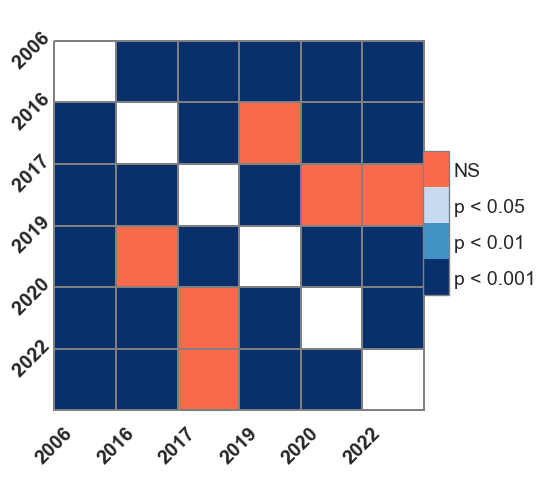

In [9]:
statistical_test(dataframes, 'dissimilarity_mean_band2')

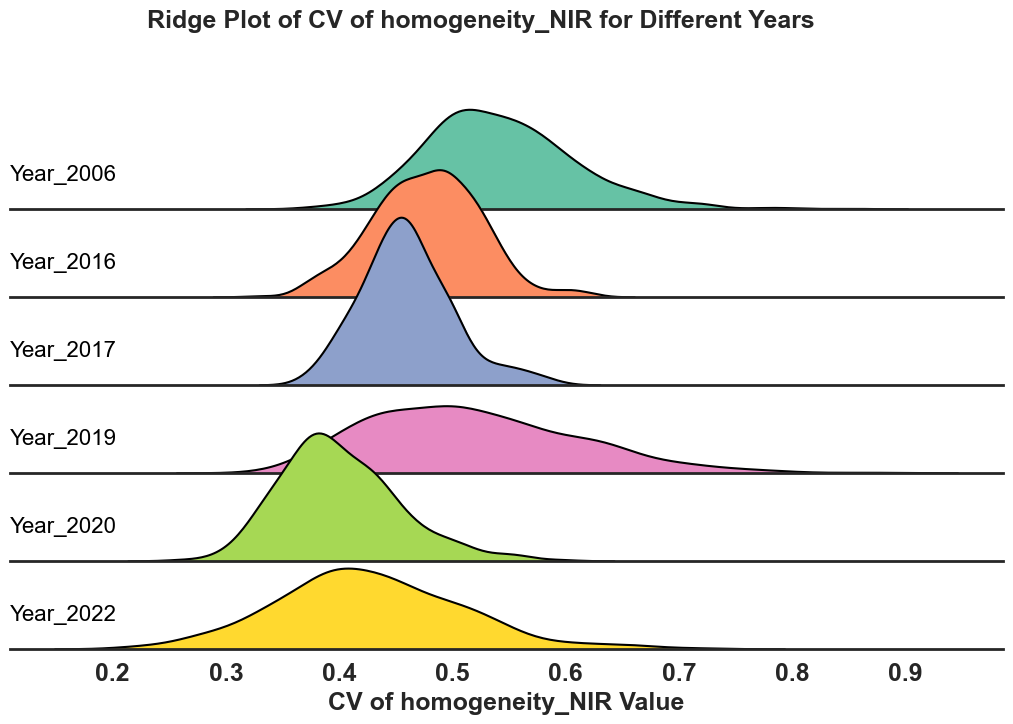

In [35]:
plot_ridge_histograms(dataframes, 'homogeneity_CV_band4', years)

Kruskal-Wallis Test - Statistic: 957.3197015847427, p-value: 1.043356321985396e-204
One-way ANOVA - Statistic: 278.7118687547679, p-value: 8.191773471378506e-235
posthoc_mannwhitney test:               1             2             3             4              5  \
1   1.000000e+00  1.157265e-63  1.366127e-34  3.227351e-09  1.110898e-127   
2   1.157265e-63  1.000000e+00  8.779841e-05  1.429404e-11   1.877821e-72   
3   1.366127e-34  8.779841e-05  1.000000e+00  1.759261e-10   1.163556e-24   
4   3.227351e-09  1.429404e-11  1.759261e-10  1.000000e+00   3.311566e-77   
5  1.110898e-127  1.877821e-72  1.163556e-24  3.311566e-77   1.000000e+00   
6   3.399382e-80  7.101631e-26  6.168603e-07  2.508661e-39   1.104035e-06   

              6  
1  3.399382e-80  
2  7.101631e-26  
3  6.168603e-07  
4  2.508661e-39  
5  1.104035e-06  
6  1.000000e+00  


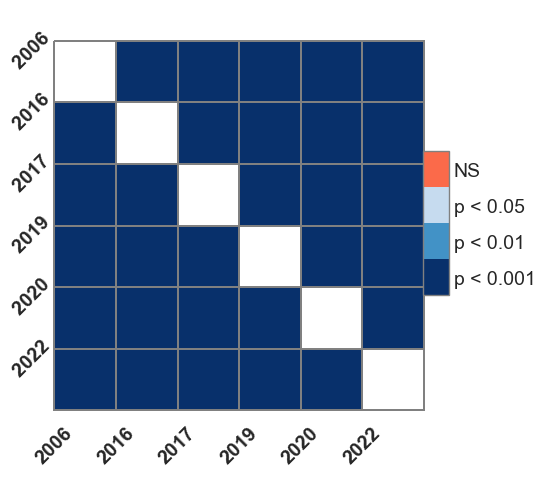

In [13]:
statistical_test(dataframes, 'homogeneity_CV_band4')

In [ ]:
mean_CV_band4
correlation_mean_band3
dissimilarity_skewness_band2 
homogeneity_skewness_band1
homogeneity_CV_band4  **
dissimilarity_mean_band2 
homogeneity_mean_band4
dissimilarity_kurtosis_band1
correlation_mean_band4
homogeneity_CV_band3 
homogeneity_skewness_band3
variance_CV_band4

Kruskal-Wallis Test - Statistic: 807.3998831345378, p-value: 2.9000637114784267e-172
One-way ANOVA - Statistic: 187.00063777426337, p-value: 3.693663114785081e-168
posthoc_mannwhitney test:               1             2             3             4              5  \
1   1.000000e+00  1.924251e-92  1.150934e-44  4.433601e-03  3.613262e-106   
2   1.924251e-92  1.000000e+00  2.696489e-07  4.715872e-44   1.772843e-19   
3   1.150934e-44  2.696489e-07  1.000000e+00  2.638475e-29   2.098855e-01   
4   4.433601e-03  4.715872e-44  2.638475e-29  1.000000e+00   2.593895e-67   
5  3.613262e-106  1.772843e-19  2.098855e-01  2.593895e-67   1.000000e+00   
6   5.365126e-16  2.663353e-13  7.638076e-15  2.031404e-06   6.809241e-32   

              6  
1  5.365126e-16  
2  2.663353e-13  
3  7.638076e-15  
4  2.031404e-06  
5  6.809241e-32  
6  1.000000e+00  


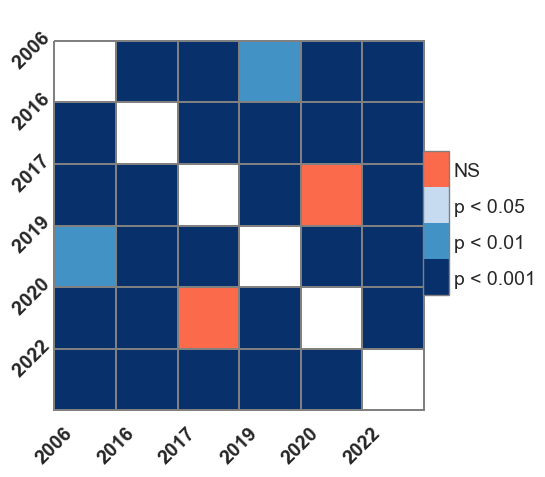

In [30]:
statistical_test(dataframes, 'variance_CV_band4')

In [37]:
import pandas as pd
import numpy as np

def print_statistics(dataframes, column_name):
    # Create an empty list to store statistics for each year
    statistics_per_year = []

    # Iterate over each dataframe
    for i, df in enumerate(dataframes):
        # Calculate descriptive statistics
        stats = df[column_name].describe()
        # Add the year as a label
        stats['Year'] = f'Year_{i + 2006}'  
        # Append statistics to the list
        statistics_per_year.append(stats)
        
    # Combine statistics for all years into a single DataFrame
    statistics_df = pd.concat(statistics_per_year, axis=1).T
    statistics_df.index = range(1, len(dataframes) + 1)  # Reset index to match years
    
    # Print the statistics
    print(statistics_df)

# Example usage
dataframes = [df1, df2, df3, df4, df5, df6]
print_statistics(dataframes, 'homogeneity_CV_band4')


   count      mean       std       min       25%       50%       75%  \
1  644.0  0.542843  0.065541  0.371962  0.498415  0.537611  0.580629   
2  480.0  0.477351  0.047065  0.330299  0.444515   0.47839   0.50981   
3  106.0  0.460104  0.039904  0.376961    0.4335  0.457387  0.483519   
4  460.0  0.518207  0.090258  0.336261  0.447433  0.506778   0.57435   
5  358.0  0.400691  0.052505    0.2626  0.365673  0.393188  0.431429   
6  324.0  0.427008  0.081203   0.22597  0.378222  0.424516  0.480265   

        max       Year  
1  0.848264  Year_2006  
2  0.619871  Year_2007  
3  0.583469  Year_2008  
4  0.866859  Year_2009  
5  0.594403  Year_2010  
6  0.716889  Year_2011  
